In [13]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [14]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

# 分類数設定

In [15]:
NUM_CLASSES = 7

# 入力長

In [16]:
TIME_STEPS = 16
DIMENSION = 4

# 学習データ読み込み

In [17]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [18]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [20]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [21]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,887 (7.37 KB)

 Trainable params: 1,887 (7.37 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [23]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [24]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
45/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1869 - loss: 1.9319   
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1966 - loss: 1.9192 - val_accuracy: 0.3233 - val_loss: 1.8052
Epoch 2/1000
53/72 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.3106 - loss: 1.7823
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3205 - loss: 1.7692 - val_accuracy: 0.4914 - val_loss: 1.5816
Epoch 3/1000
53/72 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.4398 - loss: 1.5796
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4478 - loss: 1.5662 - val_accuracy: 0.5954 - val_loss: 1.3509
Epoch 4/1000
46/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5492 - loss: 1.3973 
Epoch 4: saving model to model/point_histo

In [25]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [26]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[3.9619127e-01 5.8504987e-01 1.6812429e-02 1.5142432e-03 2.9539785e-04
 4.4413009e-05 9.2339571e-05]
1


# 混同行列

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


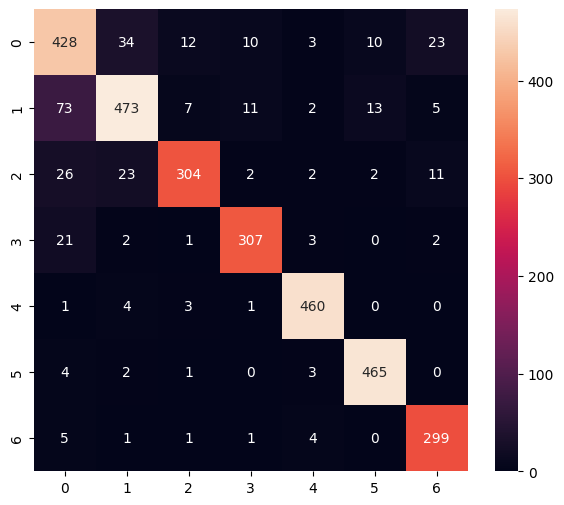

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       520
           1       0.88      0.81      0.84       584
           2       0.92      0.82      0.87       370
           3       0.92      0.91      0.92       336
           4       0.96      0.98      0.97       469
           5       0.95      0.98      0.96       475
           6       0.88      0.96      0.92       311

    accuracy                           0.89      3065
   macro avg       0.90      0.90      0.90      3065
weighted avg       0.89      0.89      0.89      3065



In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [28]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [29]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [30]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpjb1nelyd/assets


INFO:tensorflow:Assets written to: /tmp/tmpjb1nelyd/assets


Saved artifact at '/tmp/tmpjb1nelyd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140119415523280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140119415525920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140119415534192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140119415536480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140119415636736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140119415639728: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1727434232.445128   36247 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1727434232.445147   36247 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-09-27 07:50:32.445459: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjb1nelyd
2024-09-27 07:50:32.445856: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-09-27 07:50:32.445865: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpjb1nelyd
2024-09-27 07:50:32.449985: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-09-27 07:50:32.451621: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-09-27 07:50:32.474835: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpjb1nelyd
2024-09-27 07:50:32.480066: I tensorflow/cc/saved_model/loader.cc

5400

# 推論テスト

In [31]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [32]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([ 1, 64], dtype=int32), 'shape_signature': array([-1, 64], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [33]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [34]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 69 μs, sys: 7 μs, total: 76 μs
Wall time: 80.8 μs


In [35]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.949551e-01 5.864381e-01 1.670805e-02 1.480497e-03 2.816441e-04
 4.291945e-05 9.362508e-05]
1
